In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout  # Importar Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer  # Importar TfidfVectorizer
from sklearn.utils import class_weight  # Importar class_weight
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TFBertModel
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import class_weight
from xgboost import XGBClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE

In [7]:
# para mejor visualización
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

random = 81418
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['administracion'], random_state=81418)
X = train_df['textos']
y = train_df['administracion']

# transformers

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import matplotlib.pyplot as plt
import seaborn as sns


# Verificar valores nulos
print("Valores nulos en el DataFrame:")
print(train_df.isnull().sum())

# Procesamiento inicial
train_df['administracion'] = train_df['administracion'].astype(int)
train_df.rename(columns={'administracion': 'label'}, inplace=True)

# Preprocesar texto
def preprocess_text(text):
    return text.lower()

train_df['textos'] = train_df['textos'].apply(preprocess_text)

# Tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df['label'].unique()))

def tokenize_function(examples):
    return tokenizer(
        examples['textos'], 
        padding='max_length', 
        truncation=True, 
        max_length=512
    )

# Configurar K-Fold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=81418)

# Almacenar métricas de cada fold
metrics_transfoormer = []
fold_idx = 1

for train_index, val_index in kfold.split(train_df, train_df['label']):
    print(f"\nFold {fold_idx}")

    # Dividir en conjunto de entrenamiento y validación
    train_df1 = df.iloc[train_index]
    val_df1 = df.iloc[val_index]

    # Convertir los DataFrames a Datasets de Hugging Face
    train_dataset = Dataset.from_pandas(train_df1)
    val_dataset = Dataset.from_pandas(val_df1)

    # Tokenizar los datos
    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    # Configurar argumentos de entrenamiento
    training_args = TrainingArguments(
        output_dir=f'./results_fold_{fold_idx}',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=3e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        logging_dir=f'./logs_fold_{fold_idx}',
        logging_steps=10
    )

    # Definir el data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Definir el entrenador
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    # Entrenar el modelo
    trainer.train()

    # Evaluar el modelo
    predictions = trainer.predict(tokenized_val)
    pred_labels = np.argmax(predictions.predictions, axis=-1)
    true_labels = predictions.label_ids

    # Calcular métricas
    report = classification_report(true_labels, pred_labels, target_names=[str(i) for i in train_df['label'].unique()], output_dict=True)
    metrics_transfoormer.append({
        "fold": fold_idx,
        "accuracy": report['accuracy'],
        "precision": np.mean([report[label]['precision'] for label in report if label.isdigit()]),
        "recall": np.mean([report[label]['recall'] for label in report if label.isdigit()]),
        "f1": np.mean([report[label]['f1-score'] for label in report if label.isdigit()])
    })

    print(f"\nMetrics for Fold {fold_idx}:")
    print(f"Accuracy: {metrics_transfoormer[-1]['accuracy']:.4f}")
    print(f"Precision: {metrics_transfoormer[-1]['precision']:.4f}")
    print(f"Recall: {metrics_transfoormer[-1]['recall']:.4f}")
    print(f"F1 Score: {metrics_transfoormer[-1]['f1']:.4f}")

    # Graficar matriz de confusión para el fold actual
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_df['label'].unique(), yticklabels=train_df['label'].unique())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {fold_idx}")
    plt.show()

    fold_idx += 1

# Resumen de métricas finales
print("\nFinal Metrics Across All Folds:")
for metric in metrics_transfoormer:
    print(f"Fold {metric['fold']}: Accuracy={metric['accuracy']:.4f}, Precision={metric['precision']:.4f}, Recall={metric['recall']:.4f}, F1={metric['f1']:.4f}")

# Promedio de métricas
avg_metrics_transfoormer = {
    "accuracy": np.mean([m["accuracy"] for m in metrics_transfoormer]),
    "precision": np.mean([m["precision"] for m in metrics_transfoormer]),
    "recall": np.mean([m["recall"] for m in metrics_transfoormer]),
    "f1": np.mean([m["f1"] for m in metrics_transfoormer]),
}

print("\nAverage Metrics:")
print(f"Accuracy: {avg_metrics_transfoormer['accuracy']:.4f}")
print(f"Precision: {avg_metrics_transfoormer['precision']:.4f}")
print(f"Recall: {avg_metrics_transfoormer['recall']:.4f}")
print(f"F1 Score: {avg_metrics_transfoormer['f1']:.4f}")


Valores nulos en el DataFrame:
textos            0
administracion    0
dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold 1


Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

# otros modelos ML

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier


# Cargar el dataframe
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

random = 81418
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['administracion'], random_state=random)
X = train_df['textos']
y = train_df['administracion']

# Vectorización de los textos usando TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

# Definir clasificadores con hiperparámetros
classifiers = {
    "Naive Bayes": MultinomialNB(alpha=0.1),
    "Regresion Logística": LogisticRegression(random_state=81418, max_iter=20),
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=81418,max_depth=5),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.05, max_depth=10, random_state=81418),
    "SVM": SVC(C=1.0, kernel='linear', probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2),
    "AdaBoost": AdaBoostClassifier(random_state=81418),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.2, max_depth=10, subsample=0.8, random_state=81418)
}


# Configurar Stratified K-Fold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=random)

# Almacenar métricas de cada fold para otros clasificadores
clf_metrics = {name: [] for name in classifiers.keys()}

for fold_idx, (train_index, val_index) in enumerate(kfold.split(X_tfidf, y), 1):
    print(f"\nFold {fold_idx} - Classic Models")

    X_train, X_val = X_tfidf[train_index], X_tfidf[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    for name, clf in classifiers.items():
        # Entrenamiento
        clf.fit(X_train, y_train)
        
        # Predicción
        y_pred = clf.predict(X_val)
        
        # Métricas
        accuracy = accuracy_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred, average='macro')  # 'macro' para varias clases
        f1 = np.mean([classification_report(y_val, y_pred, output_dict=True)[str(i)]['f1-score'] for i in np.unique(y)])
        
        clf_metrics[name].append({
            "fold": fold_idx,
            "accuracy": accuracy,
            "recall": recall,
            "f1": f1
        })

# Crear la estructura de resultados en DataFrame para los modelos de ML
results = {
    "Model": [],
    "Accuracy": [],
    "Recall": [],
    "F1-Score": []
}

for model_name, metrics_list in clf_metrics.items():
    avg_accuracy = np.mean([metric['accuracy'] for metric in metrics_list])
    avg_recall = np.mean([metric['recall'] for metric in metrics_list])
    avg_f1 = np.mean([metric['f1'] for metric in metrics_list])
    
    results["Model"].append(model_name)
    results["Accuracy"].append(avg_accuracy)
    results["Recall"].append(avg_recall)
    results["F1-Score"].append(avg_f1)

# Crear DataFrame para los resultados
results_df = pd.DataFrame(results)



Fold 1 - Classic Models

Fold 2 - Classic Models

Fold 3 - Classic Models

Fold 4 - Classic Models

Fold 5 - Classic Models

Fold 6 - Classic Models


In [10]:
resultados = results_df

In [ ]:
# bert

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w


Fold 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Fold 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step

Fold 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Fold 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

Fold 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Fold 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


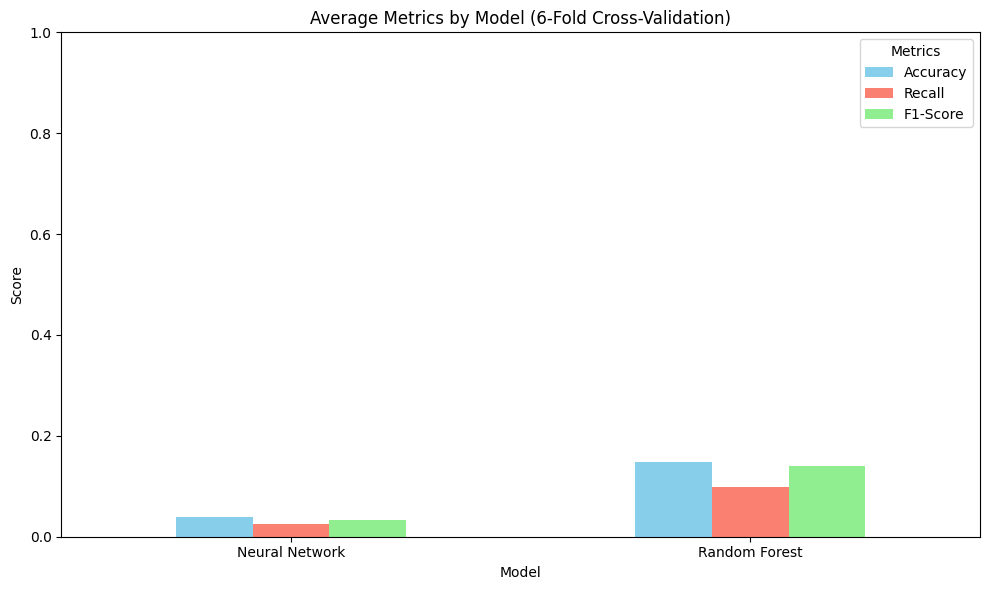

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# 1. Cargar datos
df = pd.read_csv(r'C:\Users\lazkuenaru\Desktop\TFM\pharmaceutical_extraction\src\Model\textos_patologias_linea_de_administracion.csv', 
                 encoding='utf-8-sig', delimiter=';')

random = 81418
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['administracion'], random_state=random)

# Procesamiento de etiquetas
train_df['administracion'] = train_df['administracion'].apply(lambda x: eval(x) if isinstance(x, str) else x)
X_text = train_df['textos']
y_labels = train_df['administracion'].apply(lambda x: [x] if isinstance(x, int) else x)

# Codificar etiquetas con MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_labels)

# Tokenización y Embeddings con BERT
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(), max_length=100, padding='max_length', truncation=True, return_tensors="tf"
    )

X_tokenized = tokenize_texts(X_text)
X_embeddings = bert_model(X_tokenized['input_ids']).last_hidden_state
X_pooled = tf.reduce_mean(X_embeddings, axis=1).numpy()

# Configurar Stratified K-Fold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=random)

# Almacenar métricas
metrics_nn = []
metrics_rf = []

for fold_idx, (train_index, val_index) in enumerate(kfold.split(X_pooled, y.argmax(axis=1)), 1):
    print(f"\nFold {fold_idx}")

    # Dividir los datos en TRAIN y VALIDACIÓN
    X_train, X_val = X_pooled[train_index], X_pooled[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Modelo de Red Neuronal
    model_nn = Sequential([
        Dense(128, activation='relu', input_shape=(X_pooled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(y.shape[1], activation='sigmoid')
    ])
    model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_nn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Predicción y métricas para NN
    y_pred_nn = (model_nn.predict(X_val) > 0.5).astype(int)
    accuracy_nn = accuracy_score(y_val, y_pred_nn)
    recall_nn = recall_score(y_val, y_pred_nn, average='macro')
    f1_nn = f1_score(y_val, y_pred_nn, average='macro')
    metrics_nn.append((accuracy_nn, recall_nn, f1_nn))

    # Modelo Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=random)
    rf_model.fit(X_train, y_train)

    # Predicción y métricas para RF
    y_pred_rf = rf_model.predict(X_val)
    accuracy_rf = accuracy_score(y_val, y_pred_rf)
    recall_rf = recall_score(y_val, y_pred_rf, average='macro')
    f1_rf = f1_score(y_val, y_pred_rf, average='macro')
    metrics_rf.append((accuracy_rf, recall_rf, f1_rf))

# Promedio de métricas
avg_metrics_nn = np.mean(metrics_nn, axis=0)
avg_metrics_rf = np.mean(metrics_rf, axis=0)

# Crear DataFrame para graficar
results_df = pd.DataFrame({
    "Model": ["Neural Network", "Random Forest"],
    "Accuracy": [avg_metrics_nn[0], avg_metrics_rf[0]],
    "Recall": [avg_metrics_nn[1], avg_metrics_rf[1]],
    "F1-Score": [avg_metrics_nn[2], avg_metrics_rf[2]]
})

# Bar plot de métricas promedio
metrics = ["Accuracy", "Recall", "F1-Score"]
results_df.set_index("Model")[metrics].plot(kind="bar", figsize=(10, 6), color=["skyblue", "salmon", "lightgreen"])
plt.title("Average Metrics by Model (6-Fold Cross-Validation)")
plt.ylabel("Score")
plt.ylim(0, 1)  # Métricas están entre 0 y 1
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()


In [11]:
combined_df = resultados

In [12]:
new_row = {
    "Model": "Transformer BERT",
    "Accuracy": 0.6035,
    "Recall": 0.4093,
    "F1-Score": 0.3557
}

new_row_df = pd.DataFrame([new_row])
combined_df = pd.concat([combined_df, new_row_df], ignore_index=True)

In [13]:
combined_df

,Model,Accuracy,Recall,F1-Score
0,Naive Bayes,0.484127,0.379167,0.369071
1,Regresion Logística,0.554834,0.386574,0.355593
2,Random Forest,0.578644,0.401389,0.365355
3,Gradient Boosting,0.522727,0.403241,0.381296
4,SVM,0.578283,0.413889,0.376880
5,K-Nearest Neighbors,0.437229,0.316667,0.288895
6,AdaBoost,0.470779,0.306481,0.250775
7,XGBoost,0.588023,0.445833,0.417601
8,Transformer BERT,0.603500,0.409300,0.355700


<Figure size 1000x600 with 0 Axes>

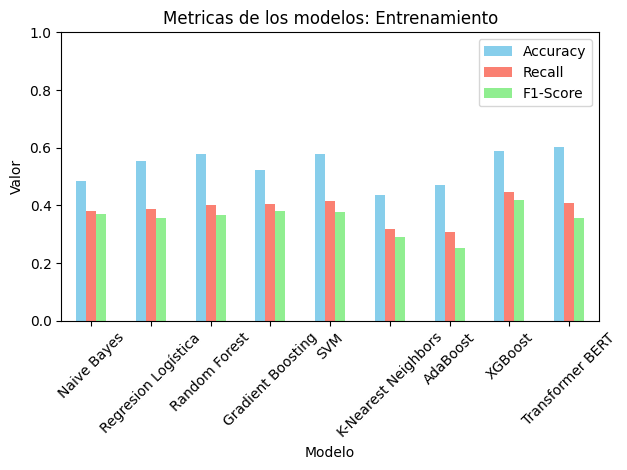

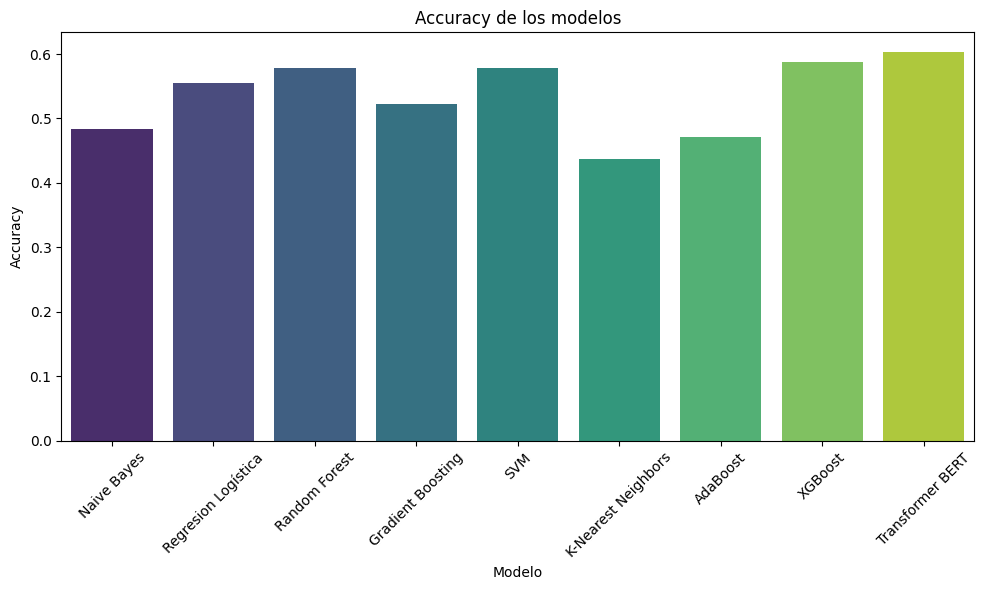

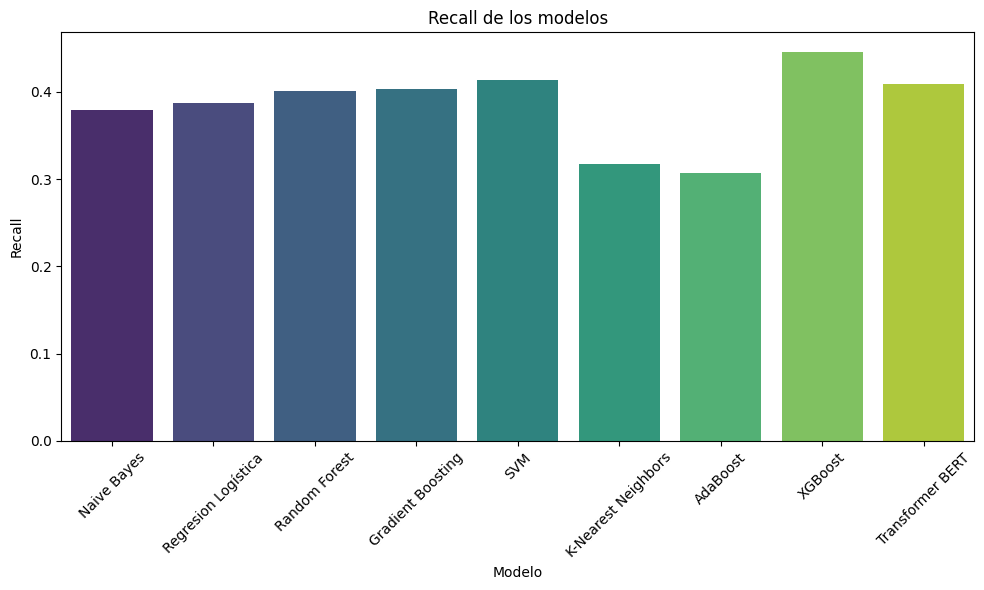

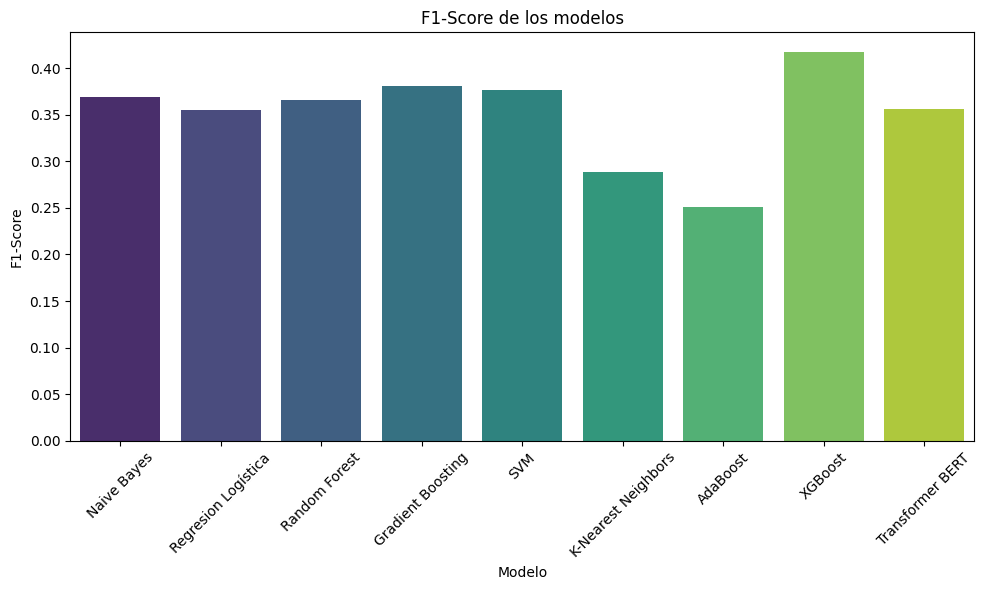

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'combined_df' tiene las columnas: 'Model', 'Accuracy', 'Recall', 'F1-Score'
# Si ya lo tienes, simplemente ejecuta este código para crear los gráficos.

# Bar plot conjunto de Accuracy, Recall, F1-Score
plt.figure(figsize=(10, 6))
combined_df.set_index("Model")[['Accuracy', 'Recall', 'F1-Score']].plot(kind="bar", color=['skyblue', 'salmon', 'lightgreen'])

plt.title("Metricas de los modelos: Entrenamiento")
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.ylim(0, 1)  # Métricas entre 0 y 1
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot individual para cada métrica
metrics = ['Accuracy', 'Recall', 'F1-Score']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y=metric, data=combined_df, palette='viridis')

    plt.title(f"{metric} de los modelos")
    plt.xlabel("Modelo")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
